In [1]:
import torchvision.transforms.autoaugment
%matplotlib inline

# Neural Networks and Learning Machines
## Exercise 5 - Convolutional ANN and Transfer learning

In [2]:
epochs = 30


# Introduction
The goal of this exercise is for you to get a better understanding of what convolution is, how it is leveraged to increase the usability and performance of neural networks. The exercise will also teach you about transfer learning and the differences between fine-tuning/feature extraction. 

## Literature
This exercise will rely on the following sections in the [course book](https://www.deeplearningbook.org/).

- Chapter 9
    - Most of it
- Chapter 7
    - Section 7.4 - Dataset augmentation
- Chapter 15
    - Section 15.2 - Transfer learning
    
## Examination
Epochs are predefined to be 30. Feel free to increase/decrease this number depending on the hardware that you are working with. Just make sure that you use the same hyperparameters on tasks 2, 3 and 4. **Make sure you have all examination requirements in order before presenting.**

### Task 1
1. Implementation of same convolution.
2. The resulting image using 3 different filters.

### Task 2
1. The given network trained, validated and tested on the given dataset. Don't forget to make the train/validation/test split of the dataset. This can be achieved programmatically using https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split.
2. Some type of regularization should be used. You should understand how the chosen regularization technique works.
3. Report the training, validation and test accuracy. (Should beat randomly picking)
4. Calculate and plot the multi-class [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).
5. Add some augmentation techniques which fits well with the data. Does this increase or decrease the validation accuracy?

### Task 3
1. Fine-tune Resnet18 on the given dataset.
2. Report the training, validation and test accuracy. (Should beat randomly picking)
3. Calculate and plot the multi-class [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).
4. Add some augmentation techniques which fits well with the data. Does this increase or decrease the validation accuracy?

### Task 4
1. Use Resnet18 as a feature extractor on the dataset.
2. Report the training, validation and test accuracy. (Should beat randomly picking)
3. Calculate and plot the multi-class [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).
4. Add some augmentation techniques which fits well with the data. Does this increase or decrease the validation accuracy?

# Convolution in Neural Networks
A convolutional neural network, CNN for short, is a type of ANN that consists of at least one convolutional layer. CNN's are often used where the input size may vary such as when we are dealing with image input. The architecture of CNNs was inspired by how the visual cortex functions in our brain.

## Task 1: Implement convolution
Implement 2d same convolution without using a built-in convolution function. This should function as described in [this blog post](https://jcbgamboa.github.io/2017/08/12/what-are-convolutions/). One of the great strengths of convolution is that it functions on any sized image, hence it is important that your implementation also does. Same convolution means that the dimensions of the output are the same as the dimensions of the input. This is achieved by padding the input.

Once you have implemented a function that performs 2d convolution, use that to perform convolution over all channels in this image. Show the result using 3 different filters.

To find the padding needed to get the input to be the same space as the output you can use the formula:

$$ n_{out} = \left \lfloor\frac{n_{in}+2p-k}{s} \right \rfloor+1 $$

where $n_{out}$ is the number of output features, $n_{in}$ is the number of input features, $k$ is the kernel size, $p$ is the padding size and $s$ is the stride size. You can assume that the stride is always 1.

In [ ]:
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 30]
plt.rcParams['figure.dpi'] = 100

# Implement same convolution in the function below (kernel is a 2d numpy array an example of which can be found in the test)
def conv(image, kernel, strides=1):
    krh = kernel.shape[0] // 2
    kch = kernel.shape[1] // 2
    acc = np.zeros_like(image)
    for ir in range(image.shape[0]):
        for ic in range(image.shape[1]):
            for kr in range(kernel.shape[0]):
                irs = ir - krh + kr
                if irs < 0 or irs >= image.shape[0]:
                    continue
                for kc in range(kernel.shape[1]):
                    ics = ic - kch + kc
                    if ics < 0 or ics >= image.shape[1]:
                        continue
                    v = kernel[kr, kc]
                    acc[ir, ic] += v * image[irs, ic - kch + kc]
    return acc

# Our test, don't edit
inp = np.array([[1,1,1,1],[1,1,2,1],[1,-3,-4,1],[1,1,1,1]])
kernel = np.array([[0,1,0],[1,2,1],[0,1,0]]) # This is the second input of conv()

# If all are TRUE the convolution is implemented correctly
ans = np.array([[4, 5, 6, 4], [5, 3, 3, 6], [1, -7, -7, 0], [4, 1, 0, 4]])
print(conv(inp, kernel) == ans)

f, axarr = plt.subplots(4,1)

# How to load images using opencv
image_path = "Vantar.jpg" # add your file path here
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # gray scale so we dont have to deal with more than 1 channel

# Define your 3 kernels
kernel_1 = np.array([[1, 0, -1],  # Sobel edge detect
                     [2, 0, -2],
                     [1, 0, -1]])
kernel_2 = np.array([[1, 2, 1],
                     [0, 0, 0],
                     [-1,-2,-1]])
kernel_3 = np.array([[0, 1, 0],  # Laplacian 2nd derivate
                     [1,-4, 1],
                     [0, 1, 0]])

# Perform the convolution (might take a couple of seconds depending on the implementation)
output1 = conv(image, kernel_1)
output2 = conv(image, kernel_2)
output3 = conv(image, kernel_3)

# plot the loaded image and the 3 convoluted images
axarr[0].imshow(image, cmap="gray")
axarr[1].imshow(output1, cmap="gray")
axarr[2].imshow(output2, cmap="gray")
axarr[3].imshow(output3, cmap="gray")

plt.show()

# Computer Vision
Computer vision (CV) is a task within the computer science field that aim is to extract high-level information from static images or video. Such high-level information can be, but is not limited to:
* Object detection - Detect and classify objects within input images
* Anomaly detection - Detect anomalies in the input images
* Semantic segmentation - Classify each pixel in the input image into different classes
* Object recognition - Classifying an entire image depending on what it contains

CV has been studied for multiple decades where early solutions used handwritten feature extractors to extract information from the input. However, with the increase of computing power together with the rise of deep learning algorithms, the main method used to solve CV problems is convolutional neural networks.

In this exercise, we will be taking a closer look at object recognition by first using a randomly initialized network and then utilizing transfer learning. **The dataset we will use for this exercise can be downloaded on canvas**. It is a subset of [this dataset](http://www.vision.caltech.edu/Image_Datasets/Caltech101/). Remember to split the data into separate training, validation and test set.

## Task 2: Implement the missing code and train it on the given dataset.
For task 2, implement the missing parts of the code below. The code should correctly train, validate and test the model. There are some comments guiding you through the process, however if something is unclear try to leverage the documentation for pytorch found [here](https://pytorch.org/docs/stable/index.html). You should also add some type of regularization into your model.

Remember to check the examination requirements in the start of this notebook.

In [3]:
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision.models as models
from torchvision import datasets
from torchvision.transforms import v2, autoaugment
from torch.utils.data import DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available()
                      else "cpu")
print("Execution device", device)


Execution device cuda:0


In [11]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 26 * 26, 120)
        self.fc2 = nn.Linear(120, 2)
#        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
#        x = self.dropout(x)
        return x

# Add training augmentations here, remember: we do not want to transform the validation images.
# For information about augmentation see: https://pytorch.org/vision/stable/transforms.html
train_transformations = v2.AutoAugment(autoaugment.AutoAugmentPolicy.SVHN,
                                       autoaugment.InterpolationMode.BILINEAR)

# Implement a train model function so you can re_use it in task 3 and 4.
# Should return the best performing model after training
def train_model_(model, criterion, optimizer, train_loader, val_loader, num_epochs, show_plot=True):
    best_loss = float('inf')
    best_model = copy.deepcopy(model)
    best_validation_accuracy = 0
    train_loss = []
    val_loss = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        # Training
        training_loss = 0
        training_accuracy = 0
        model.eval()
        for image, target in train_loader:
            image, target = train_transformations(image, target)
            estimate = model.forward(image.to(device))
            guess = torch.argmax(estimate, dim=1)
            training_accuracy += guess == target.to(device)
            loss = criterion(estimate.to(device), target)
            training_loss += loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation
        validation_loss = 0
        validation_accuracy = 0
        model.train(True)
        for image, target in val_loader:
            estimate = model.forward(image.to(device))
            guess = torch.argmax(estimate, dim=1)
            validation_accuracy += guess == target.to(device)
            loss = criterion(estimate, target)
            validation_loss += loss

        if validation_loss/len(val_loader) < best_loss:
            best_loss = validation_loss/len(val_loader)
            best_model = copy.deepcopy(model)
            best_validation_accuracy = int(validation_accuracy)/len(val_loader)
            best_training_accuracy = int(training_accuracy)/len(train_loader)
            print(f"Saving model... validation loss: {best_loss/len(val_loader):.4f} ({100*best_validation_accuracy:.1f}%) training ({100*best_training_accuracy:.1f}%)")

    return best_model, best_loss, best_validation_accuracy, best_training_accuracy


def evaluate_model(model, criterion, eval_loader):
    total_loss = 0
    confusion_matrix = torch.zeros((2, 2)).to(device)
    model.to(device)
    model.eval()
    for image, target in eval_loader:
        outv = model.forward(image.to(device))
        target = target.to(device)
        guess = torch.argmax(outv).to(device)
        confusion_matrix[guess, target] += 1
        loss = criterion(outv.squeeze(), target)
        total_loss += loss
    return confusion_matrix.cpu(), total_loss.cpu() / len(eval_loader)

# Hyperparams. Set these to reasonable values
BATCH_SIZE = 1  # TODO
LEARNING_RATE = 1e-3

# Train augmentations
plain_transformations = v2.Compose([v2.ToImage(),
                                    v2.ToDtype(torch.float32, scale=True)])

# Load the full dataset, perform the training/validation/test split and then load the subsets into dataloaders.
# Remember that the training images should be augmentated.
DATA_DIR = "101_ObjectCategories_2classes" # Path to dataset

labeled_images = datasets.ImageFolder(root=DATA_DIR, transform=plain_transformations)
print(labeled_images)

# Split dataset; training, validation, test
torch.manual_seed(1)
parts = torch.utils.data.random_split(labeled_images, [0.64, 0.16, 0.20])




Dataset ImageFolder
    Number of datapoints: 84
    Root location: 101_ObjectCategories_2classes
    StandardTransform
Transform: Compose(
                 ToImage()
                 ToDtype(scale=True)
           )


In [347]:
torch.manual_seed(42)

train_loader = DataLoader(parts[0], batch_size=BATCH_SIZE, shuffle=True)
validate_loader = DataLoader(parts[1], batch_size=BATCH_SIZE, shuffle=False)
print("Train", type(train_loader))

test_loader = DataLoader(parts[2], batch_size=BATCH_SIZE, shuffle=False)

# Load our network
model = Net().to(device)

# Define our loss function
_m = nn.Sigmoid()
_loss = torch.nn.BCELoss()
def criterion(y_est, y_true):
    return _loss(_m(y_est),
                 nn.functional.one_hot(y_true, num_classes=2).type(torch.Tensor).to(device)) # What function to use to calculate the loss given the prediction and labels

# Define our optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, weight_decay=7e-5)

# Train the model
trained_model, loss, accuracy, training_accuracy = train_model_(model, criterion, optimizer, train_loader, validate_loader, num_epochs=300)
print(f"Best validation loss: {loss}, validation accuracy: {100 * accuracy:.1f}%, training accuracy: {100 * training_accuracy:.1f}%")
# Test the model
confusion_matrix, test_loss = evaluate_model(trained_model, criterion, test_loader)
print(confusion_matrix, test_loss)
print(f"Test {100 * float(sum(torch.diagonal(confusion_matrix, 0)) / torch.sum(confusion_matrix)):.1f}%, loss={test_loss}")

Train <class 'torch.utils.data.dataloader.DataLoader'>
Epoch 1/300
Saving model... validation loss: 0.0547 (28.6%) training (51.9%)
Epoch 2/300
Saving model... validation loss: 0.0505 (28.6%) training (51.9%)
Epoch 3/300
Saving model... validation loss: 0.0500 (50.0%) training (46.3%)
Epoch 4/300
Epoch 5/300
Epoch 6/300
Epoch 7/300
Epoch 8/300
Epoch 9/300
Epoch 10/300
Epoch 11/300
Epoch 12/300
Epoch 13/300
Epoch 14/300
Saving model... validation loss: 0.0500 (42.9%) training (48.1%)
Epoch 15/300
Epoch 16/300
Epoch 17/300
Epoch 18/300
Epoch 19/300
Epoch 20/300
Epoch 21/300
Saving model... validation loss: 0.0496 (42.9%) training (57.4%)
Epoch 22/300
Epoch 23/300
Epoch 24/300
Epoch 25/300
Epoch 26/300
Epoch 27/300
Epoch 28/300
Saving model... validation loss: 0.0484 (42.9%) training (55.6%)
Epoch 29/300
Epoch 30/300
Epoch 31/300
Epoch 32/300
Epoch 33/300
Epoch 34/300
Epoch 35/300
Epoch 36/300
Epoch 37/300
Epoch 38/300
Epoch 39/300
Saving model... validation loss: 0.0480 (42.9%) training 

# Transfer learning
Transfer learning refers to the practice to use a model which has already been pre-trained on a large dataset to be able to solve task $T_1$, replace the output layer or a few of the upper layers within this model and retrain the model on a smaller dataset to be able to solve task $T_2$. Formally this can be described as the following:

__Def 1:__ Let $D_s$ be the source domain and $T_s$ be the corresponding source task. Let $D_t$ be the target domain and $T_t$ be the corresponding target task. Let $f_t$ be the predictive function for $T_s$. Thus transfer learning aims to improve the learning of $f_t$ in $D_t$ using the already learned knowledge in $D_s$ and $T_s$ where $D_s \neq D_t$ and $T_s \neq T_t$.

The benefit from using transfer learning is that we can train an accurate computer vision model with relatively small amounts of data and computing resources compared to the costly pretraining process of the full convolutional neural network (a few days using multiple GPUs). 

## Fine-tuning and Feature extraction
There are two main ideas when it comes to transfer learning, fine-tuning and feature extraction. When using fine-tuning we allow all weights to be changed during the training phase. However, when we use the pre-trained model as a feature extractor we instead freeze earlier layers of the model, which means that the weights in those layers will not be updated during the training phase and we only update the weights in the upper layers that we have replaced. 

This works because low-level information extracted from the input image is universal between tasks, examples of such information is edge detection, shape detection and pattern detection. This is what the early layers are optimized to do, where later layers extract more abstract features relevant for the task. 

Most of the pre-trained models in PyTorch are trained on [ImageNet](http://www.image-net.org/). 

In this exercise, we use ResNet18 as our model. You should make yourself familiar with the Resnet18 architecture using, for example, [the paper](https://arxiv.org/abs/1512.03385).

## Task 3: Fine-tuning
In task 3 you should *fine-tune Resnet18 to the small dataset* which is provided above. Some code has been given to you. Remember to re-use functions (such as trained_model) from task 2 to decrease the implementation time.

Remember to check the examination requirements at the start of this notebook.

In [12]:
# Fine-tune a model to the dataset
# We use resnet18 as the model.
torch.manual_seed(44)

import numpy as np
import matplotlib.pyplot as plt
# train model function
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs = 10, show_plot = True):

    min_loss = 10000
    max_acc = 0
    # Track loss
    training_loss, validation_loss = [], []

    # Track accuracy
    training_acc, validation_acc = [], []

    for i in range(num_epochs):
        # Track loss
        epoch_training_loss, epoch_validation_loss = 0, 0
        train_size, val_size = 0, 0

        # track accuracy
        train_correct, val_correct = 0, 0

        # training
        model.train(True)
        for batch_nr, (data, labels) in enumerate(train_loader):
            data, labels = train_transformations(data, labels)
            # predict
            data = data.to(device)
            labels = labels.to(device)

            pred = model(data)
            pred = torch.squeeze(pred)

            # calculate accuracy
            preds = torch.argmax(pred)
            train_correct += torch.sum(preds==labels).item()

            # Clear stored gradient values
            optimizer.zero_grad()
            loss = criterion(pred.squeeze(), labels)

            # Backpropagate the loss through the network to find the gradients of all parameters
            loss.backward()

            # Update the parameters along their gradients
            optimizer.step()

            # Update loss
            epoch_training_loss += loss.cpu().detach().numpy()
            train_size = batch_nr

        # validation
        model.eval()
        for data, labels in val_loader:
            data = data.to(device)
            labels = labels.to(device)
            # predict

            pred = model(data)
            pred = torch.squeeze(pred)

            # calculate accuracy
            preds = torch.argmax(pred)

            val_correct += torch.sum(preds==labels).item()

            # calculate loss
            loss = criterion(pred.squeeze(), labels)
            epoch_validation_loss += loss.cpu().detach().numpy()

        # check if loss is smaller than before, if so safe model
        if epoch_validation_loss/len(val_loader) < min_loss:
            print(f" - Validation loss improved from {min_loss} to {epoch_validation_loss/len(val_loader)}")
            best_model = copy.deepcopy(model)
            torch.save(model, 'best_model_loss.pt')
            min_loss = epoch_validation_loss/len(val_loader)

        if max_acc < (val_correct/len(val_loader)):
            print(f" - Validation accuracy improved from {100*max_acc:.1f}% to {100*val_correct/len(val_loader):.1f}%")
            torch.save(model, 'best_model_acc.pt')
            max_acc = val_correct/len(val_loader)

        # Save loss for plot
        validation_loss.append(epoch_validation_loss/len(val_loader))
        training_loss.append(epoch_training_loss/train_size)

        # Save accuracy for plot
        training_acc.append(train_correct/len(train_loader))
        validation_acc.append(val_correct/len(val_loader))

        print(f'Epoch {i:3d}, training loss: {training_loss[-1]} ({100*train_correct/len(train_loader):.1f}%), validation loss: {validation_loss[-1]} ({100*val_correct/len(val_loader):.1f}%)')

        torch.save(model, 'latest_model_last.pt')

    if show_plot:
        # Plot training and validation loss
        epoch = np.arange(num_epochs)
        plt.figure(figsize=(8,4), dpi=100)
        plt.plot(epoch, training_loss, 'r', label='Training loss',)
        plt.plot(epoch, validation_loss, 'b', label='Validation loss')
        plt.legend()
        plt.xlabel('Epoch'), plt.ylabel('Loss')
        plt.show()

        # Plot training and validation accuracy
        plt.figure(figsize=(8,4), dpi=100)
        plt.plot(epoch, training_acc, 'r', label='Training accuracy',)
        plt.plot(epoch, validation_acc, 'b', label='Validation accuracy')
        plt.legend()
        plt.xlabel('Epoch'), plt.ylabel('Accuracy')
        plt.show()

    return best_model, min_loss

import optuna
train_loader = DataLoader(parts[0], batch_size=BATCH_SIZE, shuffle=True)
validate_loader = DataLoader(parts[1], batch_size=BATCH_SIZE, shuffle=False)
print("Train", type(train_loader))

test_loader = DataLoader(parts[2], batch_size=BATCH_SIZE, shuffle=False)

optimizer_dict = {
    "SGD": torch.optim.SGD,
    "Adam": torch.optim.Adam,
}


Train <class 'torch.utils.data.dataloader.DataLoader'>


[I 2024-03-10 20:31:21,738] A new study created in memory with name: no-name-eedde16d-cb8c-463a-ae32-d88bf6301a87


Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

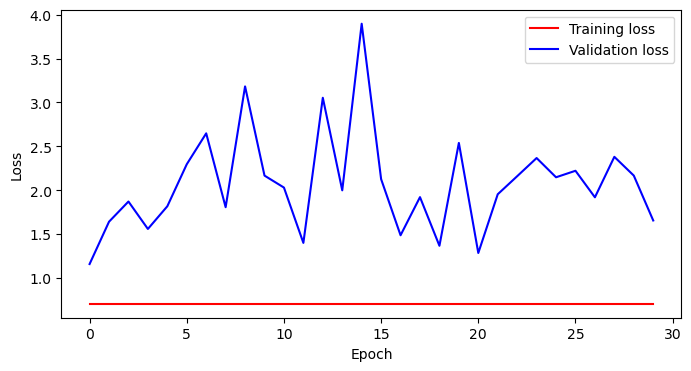

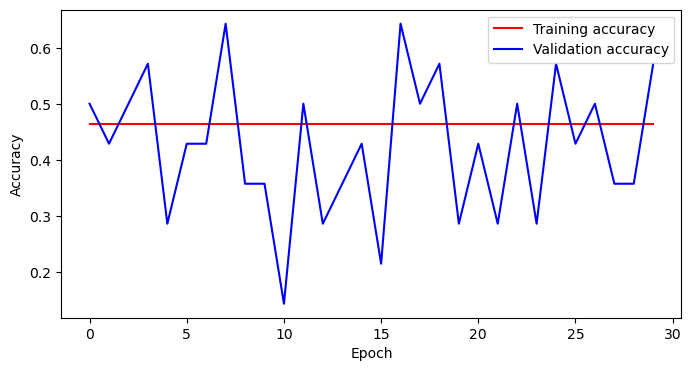

[I 2024-03-10 20:31:42,373] Trial 0 finished with value: 31.25 and parameters: {'seed': 41, 'lr': 1.1262797458908041e-05, 'weight_decay': 1.6848482360652294e-05, 'optimizer': 'Adam'}. Best is trial 0 with value: 31.25.


torch.Size([1, 2]) torch.Size([1])
torch.Size([1, 2]) torch.Size([1])
torch.Size([1, 2]) torch.Size([1])
torch.Size([1, 2]) torch.Size([1])
torch.Size([1, 2]) torch.Size([1])
torch.Size([1, 2]) torch.Size([1])
torch.Size([1, 2]) torch.Size([1])
torch.Size([1, 2]) torch.Size([1])
torch.Size([1, 2]) torch.Size([1])
torch.Size([1, 2]) torch.Size([1])
torch.Size([1, 2]) torch.Size([1])
torch.Size([1, 2]) torch.Size([1])
torch.Size([1, 2]) torch.Size([1])
torch.Size([1, 2]) torch.Size([1])
torch.Size([1, 2]) torch.Size([1])
torch.Size([1, 2]) torch.Size([1])
tensor([[5., 1.],
        [4., 6.]]) tensor(2.0547, grad_fn=<DivBackward0>)
 - Validation loss improved from 10000 to 1.2112704359128006
 - Validation accuracy improved from 0.0% to 42.9%
Epoch   0, training loss: 0.7072727882637168 (46.3%), validation loss: 1.2112704359128006 (42.9%)
Epoch   1, training loss: 0.7072727882637168 (46.3%), validation loss: 2.373274321800896 (35.7%)
Epoch   2, training loss: 0.7072727882637168 (46.3%), val

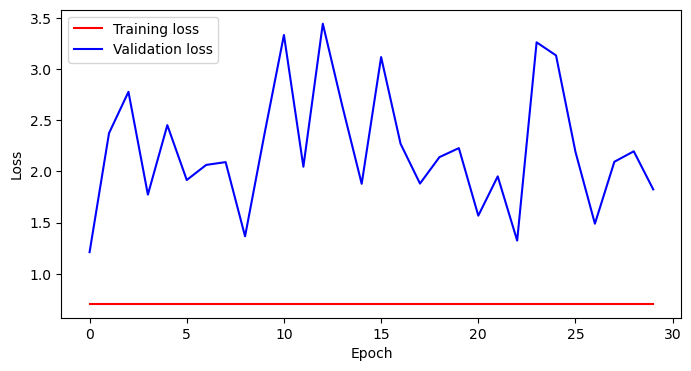

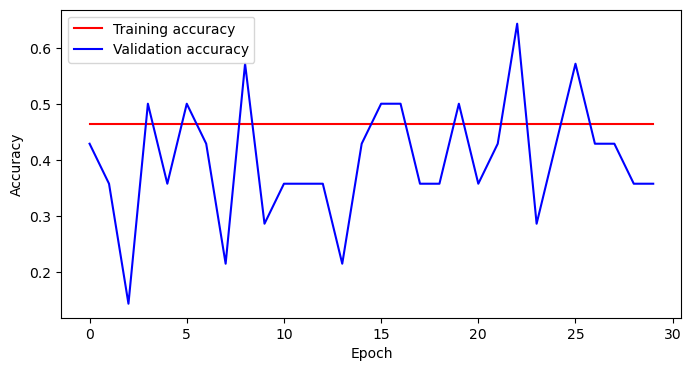

[I 2024-03-10 20:32:02,466] Trial 1 finished with value: 37.5 and parameters: {'seed': 45, 'lr': 1.8611216804855643e-06, 'weight_decay': 7.951104314731124e-05, 'optimizer': 'Adam'}. Best is trial 0 with value: 31.25.


torch.Size([1, 2]) torch.Size([1])
torch.Size([1, 2]) torch.Size([1])
torch.Size([1, 2]) torch.Size([1])
torch.Size([1, 2]) torch.Size([1])
torch.Size([1, 2]) torch.Size([1])
torch.Size([1, 2]) torch.Size([1])
torch.Size([1, 2]) torch.Size([1])
torch.Size([1, 2]) torch.Size([1])
torch.Size([1, 2]) torch.Size([1])
torch.Size([1, 2]) torch.Size([1])
torch.Size([1, 2]) torch.Size([1])
torch.Size([1, 2]) torch.Size([1])
torch.Size([1, 2]) torch.Size([1])
torch.Size([1, 2]) torch.Size([1])
torch.Size([1, 2]) torch.Size([1])
torch.Size([1, 2]) torch.Size([1])
tensor([[4., 1.],
        [5., 6.]]) tensor(1.2458, grad_fn=<DivBackward0>)
{'seed': 41, 'lr': 1.1262797458908041e-05, 'weight_decay': 1.6848482360652294e-05, 'optimizer': 'Adam'}


NameError: name 'trained_model_ft' is not defined

In [10]:

epochs = 30

model_ft = models.resnet18(pretrained=True)
model_ft.fc = nn.Dropout(1, inplace=False)
model_ft = nn.Sequential(
    model_ft,
    nn.Linear(in_features=512, out_features=2)
)
model_ft.to(device)

print(model_ft)
# Do the things required for fine-tuning before training the model
loss_ft = torch.nn.BCEWithLogitsLoss().to(device)
def criterion_ft(y_est, y_true):
    y_true = nn.functional.one_hot(y_true.long(), num_classes=2)[0].float()
    result = loss_ft(y_est,
                     y_true) # What function to use to calculate the loss given the prediction and labels
    return result

#optimizer = torch.optim.Adam(model_ft.parameters(), lr=1) #, weight_decay=7e-5)
#optimizer = torch.optim.SGD(model_ft.parameters(), lr=1e-3, weight_decay=7e-5)

# Train the model
#trained_model_ft, loss = train_model(model_ft, criterion_ft, optimizer, train_loader, validate_loader, epochs)

def objective(trial):
    seed = trial.suggest_int('seed', 40, 45)
    lr = trial.suggest_float('lr', 1e-8, 1e-3, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1, log=True)
    optimizer_fn = optimizer_dict[trial.suggest_categorical("optimizer", ["SGD", "Adam"])]
    optimizer = optimizer_fn(model_ft.parameters(), lr=lr, weight_decay=weight_decay)

    # Train the model
    torch.manual_seed(seed)

    trained_model_ft, loss = train_model(copy.deepcopy(model_ft), criterion_ft, optimizer, train_loader, validate_loader, epochs)
    confusion_matrix, test_loss = evaluate_model(trained_model_ft, criterion_ft, test_loader)
    print(confusion_matrix, test_loss)
    return 100 - 100 * float(sum(torch.diagonal(confusion_matrix, 0)) / torch.sum(confusion_matrix))

study = optuna.create_study()
study.optimize(objective, n_trials=2)
print(study.best_params)

# Test the model
confusion_matrix, test_loss = evaluate_model(trained_model_ft, criterion_ft, test_loader)
print(confusion_matrix, test_loss)
print(f"Test {100 * float(sum(torch.diagonal(confusion_matrix, 0)) / torch.sum(confusion_matrix)):.1f}%, loss={test_loss}")

In [138]:
# Resnet feature 310 is "ant"

model_unmodified = models.resnet18(pretrained=True).to(device)
def evaluate_model_310(model, criterion, eval_loader):
    total_loss = 0
    confusion_matrix = torch.zeros((2, 2))
    for image, target in eval_loader:
        outv = model.forward(image.to(device))
        guess = 0 if outv[0, 310] > 0.25 else 1
#        print(target, ".", guess, ".", outv[0,310], "wrong" if guess != int(target) else "")
        if guess != int(target):
            print(target, ".", guess, ".", outv[0,310])
        confusion_matrix[guess, target] += 1
    return confusion_matrix

confusion_matrix = evaluate_model_310(model_unmodified, criterion_ft, test_loader)
print(confusion_matrix, test_loss)
print(f"Test {100 * float(sum(torch.diagonal(confusion_matrix, 0)) / torch.sum(confusion_matrix)):.1f}%, loss={test_loss}")

tensor([1]) . 0 . tensor(0.6942, device='cuda:0', grad_fn=<SelectBackward0>)
tensor([1]) . 0 . tensor(0.4644, device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0]) . 1 . tensor(0.1806, device='cuda:0', grad_fn=<SelectBackward0>)
tensor([1]) . 0 . tensor(0.4553, device='cuda:0', grad_fn=<SelectBackward0>)
tensor([1]) . 0 . tensor(0.4917, device='cuda:0', grad_fn=<SelectBackward0>)
tensor([1]) . 0 . tensor(0.3054, device='cuda:0', grad_fn=<SelectBackward0>)
tensor([[8., 5.],
        [1., 2.]]) tensor(0.6918, device='cuda:0', grad_fn=<DivBackward0>)
Test 62.5%, loss=0.6918244957923889


## Task 4: Feature extraction
In task 4, you should use Resnet18 as a feature extractor. Similarly to task 3, some code has been provided. Remember to re-use as much code as you can. 

Once again, check the examination requirements so you don't forget to implement some required functionality.

In [ ]:
epocs = 100

# Use a predefined model as a feature extractor
# We use frezed resnet18 as the model.
model_fe = models.resnet18(pretrained=True)
for param in model_fe.parameters():
    param.requires_grad = False

# Do the things required for fine-tuning before training the model
model_fe = nn.Sequential(
        model_fe,
        nn.Linear(in_features=1000, out_features=2),
    ).to(device)


loss_fe = torch.nn.BCEWithLogitsLoss().to(device)
def criterion_fe(y_est, y_true):
    y_true = nn.functional.one_hot(y_true.long(), num_classes=2)[0].float()
    result = loss_fe(y_est,
                     y_true) # What function to use to calculate the loss given the prediction and labels
    return result

def objective(trial):
    seed = trial.suggest_int('seed', 40, 45)
    lr = trial.suggest_float('lr', 1e-8, 1e-3, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1, log=True)
    optimizer_fn = optimizer_dict[trial.suggest_categorical("optimizer", ["SGD", "Adam"])]
    optimizer = optimizer_fn(model_fe.parameters(), lr=lr, weight_decay=weight_decay)

    # Train the model
    torch.manual_seed(seed)

    trained_model_fe, loss = train_model(copy.deepcopy(model_fe), criterion_fe, optimizer, train_loader, validate_loader, epochs)
    confusion_matrix, test_loss = evaluate_model(trained_model_fe, criterion_fe, test_loader)
    print(confusion_matrix, test_loss)
    return 100 - 100 * float(sum(torch.diagonal(confusion_matrix, 0)) / torch.sum(confusion_matrix))

study = optuna.create_study()
study.optimize(objective, n_trials=1, n_jobs=2)
print(study.best_params)

# Find best parameters
optimizer_fn = optimizer_dict[study.best_params["optimizer"]]
optimizer = optimizer_fn(model_fe.parameters(), lr=study.best_params['lr'], weight_decay=study.best_params['weight_decay'])

# Test best parameters
torch.manual_seed(study.best_params['seed'])

trained_model_fe, loss = train_model(copy.deepcopy(model_fe), criterion_fe, optimizer, train_loader, validate_loader, epochs)
confusion_matrix, test_loss = evaluate_model(trained_model_fe, criterion_fe, test_loader)
print(confusion_matrix, test_loss)
print(f"Test {100 * float(sum(torch.diagonal(confusion_matrix, 0)) / torch.sum(confusion_matrix)):.1f}%, loss={test_loss}")

